In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.layers import Conv2D, Activation, Input, Flatten, Dense, LeakyReLU
from os.path import join
from deepsky.gan import unscale_multivariate_data, rescale_data
import keras.backend as K
from deepsky.kriging import random_field_generator
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"


Using TensorFlow backend.


In [2]:
gan_path = "/scratch/dgagne/random_gan_20170905/"
gan_params = pd.read_csv(join(gan_path, "gan_param_combos.csv"), index_col="Index")

In [18]:
gan_params.loc[360]

activation                  selu
batch_size                   256
beta_one                     0.5
data_width                    32
dropout_alpha                  0
filter_width                   3
generator_input_size         128
learning_rate             0.0001
length_scale              full;3
min_conv_filters              32
min_data_width                 4
output_activation         linear
seed                    14268489
train_size                131072
Name: 360, dtype: object

In [6]:
gan_params.loc[gan_params["length_scale"] == "full;3"]

(162, 14)

In [12]:
scaling_values

,Channel,mean,std
0,0,-0.000341,0.999781


In [12]:
gan_diag_preds = gan_gen.predict(0 * np.identity(16))

In [3]:
x = np.arange(32)
y = np.arange(32)
x_g, y_g = np.meshgrid(x, y)
field_gen = random_field_generator(x_g, y_g, [3])
test_fields = np.array([next(field_gen) for x in range(100)])

In [4]:
gan_sub_params = gan_params.loc[gan_params["length_scale"] == "full;3"]
sample_scores = pd.DataFrame(index=gan_sub_params.index, columns=["ME", "RMSE", "MAE"])
epoch = 10
for g_index in gan_sub_params.index:
    session = K.tf.Session(config=K.tf.ConfigProto(allow_soft_placement=True,
                                                           gpu_options=K.tf.GPUOptions(allow_growth=True),
                                                           log_device_placement=False))
    K.set_session(session)
    with K.tf.device("/gpu:{0:d}".format(0)):
        gan_gen = load_model(join(gan_path, "gan_generator_{0:04d}_epoch_{1:04d}.h5".format(g_index, epoch)))
        gan_enc = load_model(join(gan_path, "gan_encoder_{0:04d}_epoch_{1:04d}.h5".format(g_index, epoch)))
        gan_recreations = gan_gen.predict(gan_enc.predict(test_fields))
        diffs = gan_recreations - test_fields
        sample_scores.loc[g_index, "ME"] = np.mean(diffs)
        sample_scores.loc[g_index, "RMSE"] = np.sqrt(np.mean(diffs ** 2))
        sample_scores.loc[g_index, "MAE"] = np.mean(np.abs(diffs))
        print(g_index)
        print(sample_scores.loc[g_index])
        del diffs
        del gan_gen
        del gan_enc
        del gan_recreations
    session.close()

0
ME      0.0385602
RMSE      1.07657
MAE       0.85148
Name: 0, dtype: object
1
ME      2.11076
RMSE    5.78123
MAE     4.66973
Name: 1, dtype: object
2
ME      0.256491
RMSE     1.10501
MAE     0.879622
Name: 2, dtype: object
18
ME     -0.120072
RMSE     1.02335
MAE      0.81169
Name: 18, dtype: object
19
ME      0.0453762
RMSE      1.03315
MAE      0.820988
Name: 19, dtype: object
20
ME      0.0213121
RMSE      1.09947
MAE      0.874559
Name: 20, dtype: object
36
ME     -0.00510256
RMSE      0.996549
MAE       0.790779
Name: 36, dtype: object
37
ME      0.000613064
RMSE        1.12189
MAE        0.881718
Name: 37, dtype: object
38
ME     -0.0585965
RMSE      1.02399
MAE      0.815583
Name: 38, dtype: object
54
ME     -0.0576347
RMSE      1.08845
MAE      0.866236
Name: 54, dtype: object
55
ME      0.136864
RMSE     1.11734
MAE     0.889393
Name: 55, dtype: object
56
ME     -0.248397
RMSE     1.19457
MAE     0.952229
Name: 56, dtype: object
72
ME     -0.026496
RMSE     1.04391
MAE   

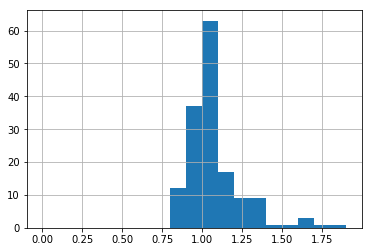

In [9]:
sample_scores["RMSE"].hist(bins=np.arange(0, 2, 0.1))

In [28]:
sample_scores = sample_scores.astype(np.float32)

In [29]:
sample_score_params = pd.merge(sample_scores, gan_params, left_index=True, right_index=True)

In [38]:
sample_score_params.columns

Index(['ME', 'RMSE', 'MAE', 'activation', 'batch_size', 'beta_one',
       'data_width', 'dropout_alpha', 'filter_width', 'generator_input_size',
       'learning_rate', 'length_scale', 'min_conv_filters', 'min_data_width',
       'output_activation', 'seed', 'train_size'],
      dtype='object')

In [44]:
sample_score_params.groupby(["activation", "generator_input_size"])["RMSE"].apply(np.argmin)

activation  generator_input_size
leaky       16                      864
            32                      882
            128                     901
relu        16                      270
            32                      289
            128                     307
selu        16                      324
            32                      342
            128                     360
Name: RMSE, dtype: int64

In [48]:
sample_score_params.loc[360]

ME                      0.0172523
RMSE                      0.84316
MAE                      0.669984
activation                   selu
batch_size                    256
beta_one                      0.5
data_width                     32
dropout_alpha                   0
filter_width                    3
generator_input_size          128
learning_rate              0.0001
length_scale               full;3
min_conv_filters               32
min_data_width                  4
output_activation          linear
seed                     14268489
train_size                 131072
Name: 360, dtype: object

In [47]:
gan_index = 360
epoch = 10
session = K.tf.Session(config=K.tf.ConfigProto(allow_soft_placement=True,
                                                           gpu_options=K.tf.GPUOptions(allow_growth=True),
                                                           log_device_placement=False))
K.set_session(session)
gan_gen = load_model(join(gan_path, "gan_generator_{0:04d}_epoch_{1:04d}.h5".format(gan_index, epoch)))
gan_enc = load_model(join(gan_path, "gan_encoder_{0:04d}_epoch_{1:04d}.h5".format(gan_index, epoch)))

scaling_values = pd.read_csv(join(gan_path, "scaling_values_{0:04d}.csv".format(gan_index)))

In [47]:
layer = gan_gen.layers[8]
get_activations = K.function([gan_gen.layers[0].input, K.learning_phase()], [layer.output,])
activations = get_activations([2 * np.identity(16), 0])[0]

In [36]:
def make_act_quilt(activations, ex):
    row = 0
    col = 0
    dim = int(np.sqrt(np.prod(activations.shape[1:])))
    width = activations.shape[1]
    act_quilt = np.zeros((dim, dim))
    for i in range(activations.shape[-1]):
        act_quilt[row:row+width, col:col+width] = activations[ex, :, :, i]
        if row < dim - width:
            row += width
        else:
            row = 0
            col += width
    return act_quilt
                  


In [32]:
act_quilt

array([[-0.03492292, -0.01734546, -0.01591329, ..., -0.0168224 ,
        -0.01606885, -0.0094415 ],
       [-0.00709019, -0.00990508, -0.01510969, ..., -0.01003858,
        -0.00277421, -0.01548788],
       [-0.00814182, -0.01293612, -0.00496435, ..., -0.00516959,
        -0.00715745, -0.01283018],
       ..., 
       [-0.00573373, -0.01342765, -0.01075676, ...,  0.0124332 ,
        -0.00300382, -0.0122514 ],
       [-0.01531009, -0.01363903, -0.01338373, ..., -0.01706735,
         0.00151476, -0.00050488],
       [-0.00192325, -0.01298147, -0.00163521, ..., -0.01773006,
        -0.01704599, -0.02076046]])

In [48]:
for i in range(16):
    act_quilt = make_act_quilt(activations, i)
    dim = int(np.sqrt(np.prod(activations.shape[1:])))
    width = activations.shape[1]
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(act_quilt, cmap="RdBu", vmin=-0.5, vmax=0.5)
    plt.xticks(np.arange(0, dim + width, width))
    plt.yticks(np.arange(0, dim + width, width))
    plt.grid()
    plt.title("Second Convolution Layer Activations Input 1 at Position {0:d}".format(i))
    plt.savefig("all_twos/conv_act_layer_2_ex_{0:02d}.png".format(i), dpi=300, bbox_inches="tight")
    plt.close()

In [9]:
dense_weights = gan_gen.layers[1].get_weights()

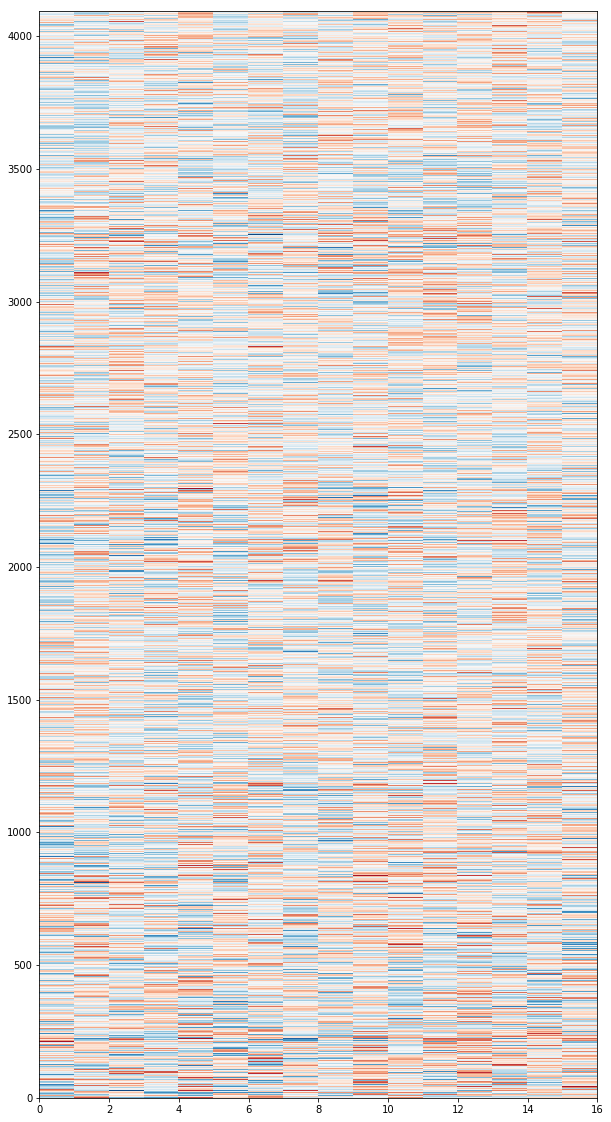

In [76]:
ext = np.max(np.abs(dense_weights[0]))
plt.figure(figsize=(10, 20))
plt.pcolormesh(dense_weights[0].T, vmin=-ext, vmax=ext, cmap="RdBu_r")

In [ ]:
plt.boxplot(dense_weights[0].T)

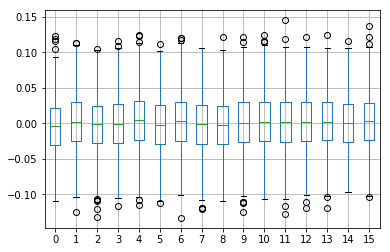

In [11]:
pd.DataFrame(dense_weights[0].T).boxplot()

In [56]:
conv_weights = gan_gen.layers[7].get_weights()[0]
conv_quilt = np.zeros((5 * 128, 5 * 64))
row = 0
col = 0
for fil in range(128):
    for lev in range(64):
        conv_quilt[fil * 5: fil * 5 + 5, lev * 5: lev * 5 + 5] = conv_weights[:, :, lev, fil]

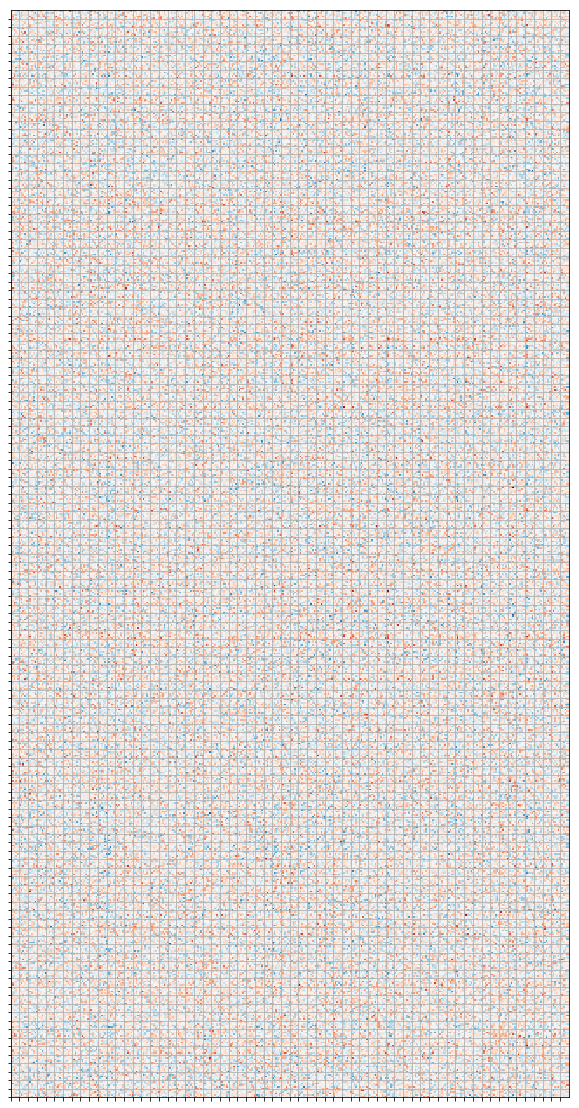

In [76]:
fig, ax = plt.subplots(figsize=(10, 20))
plt.pcolormesh(conv_quilt, vmin=-0.14, vmax=0.14, cmap="RdBu_r")
plt.xticks(np.arange(0, 64 * 5, 5), np.arange(64))
plt.yticks(np.arange(0, 128 * 5, 5), np.arange(128))
plt.grid()
ax.set_xticklabels([])
ax.set_yticklabels([])
#ax.set_xticks([])
#ax.set_yticks([])
plt.savefig("gen_conv_filters_set_2.png", dpi=400, bbox_inches="tight")

In [72]:
conv_quilt.max()

0.13600747287273407

In [84]:
conv_weights_final = gan_gen.layers[10].get_weights()[0]
conv_quilt_final = np.zeros((5 * 8, 5 * 8))
row = 0
col = 0
for fil in range(64):
    conv_quilt_final[row * 5: row * 5 + 5, col * 5: col * 5 + 5] = conv_weights[:, :, 0, fil]
    if row < 7:
        row += 1
    else:
        row = 0
        col += 1

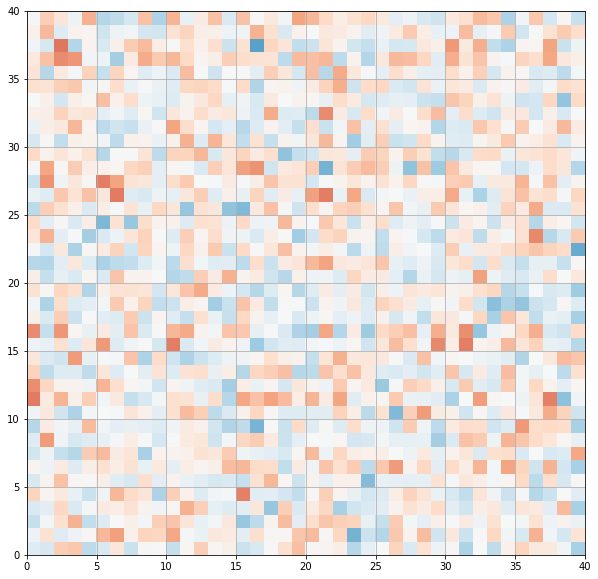

In [88]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(conv_quilt_final, vmin=-0.15, vmax=0.15, cmap="RdBu_r")
plt.grid()

In [49]:
reg_vecs = np.tile(np.linspace(-3, 3, 25), 128).reshape(128, 25).T
reg_vecs

array([[-3.  , -3.  , -3.  , ..., -3.  , -3.  , -3.  ],
       [-2.75, -2.75, -2.75, ..., -2.75, -2.75, -2.75],
       [-2.5 , -2.5 , -2.5 , ..., -2.5 , -2.5 , -2.5 ],
       ..., 
       [ 2.5 ,  2.5 ,  2.5 , ...,  2.5 ,  2.5 ,  2.5 ],
       [ 2.75,  2.75,  2.75, ...,  2.75,  2.75,  2.75],
       [ 3.  ,  3.  ,  3.  , ...,  3.  ,  3.  ,  3.  ]])

In [50]:
reg_out = gan_gen.predict(reg_vecs)

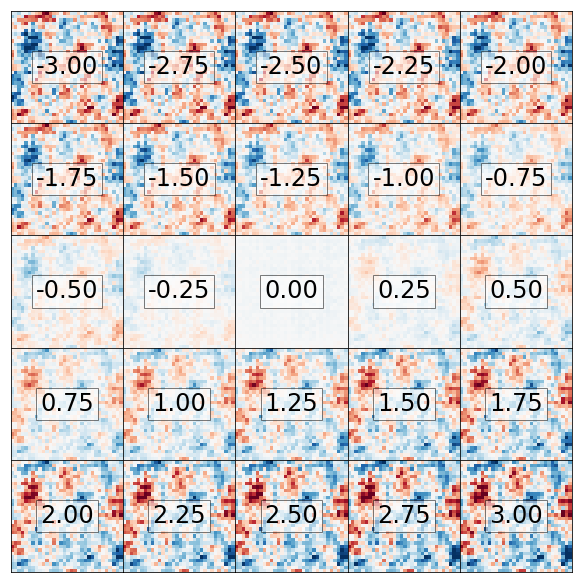

In [51]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
plt.subplots_adjust(0.02, 0.02, 0.8, 0.8, wspace=0, hspace=0)
axef = axes.ravel()
for a, ax in enumerate(axef):
    ax.pcolormesh(reg_out[a, :, :, 0], vmin=-4, vmax=4, cmap="RdBu_r")
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.text(16, 16, "{0:1.2f}".format(reg_vecs[a, 0]), fontsize=24, color="k", ha="center", va="center", bbox=dict(facecolor='w', alpha=0.5))

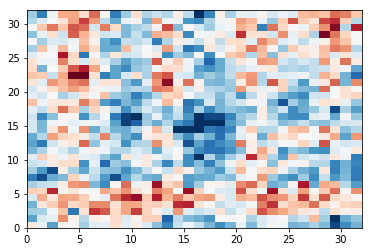

In [29]:
plt.pcolormesh(reg_out[0, :, :, 0] + reg_out[-1, :, :, 0], vmin=-4, vmax=4, cmap="RdBu_r")

In [53]:
enc_out = gan_enc.predict(gan_gen.predict(3 * np.identity(128)))

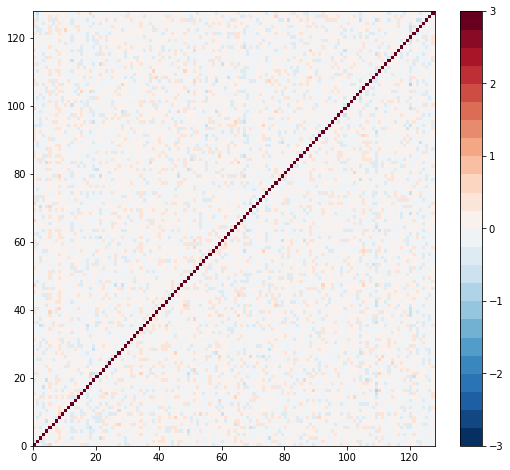

In [54]:
plt.figure(figsize=(9,8))
plt.pcolormesh(enc_out, vmin=-3, vmax=3, cmap=plt.get_cmap("RdBu_r", 24))
plt.colorbar()

In [55]:
x = np.arange(32)
y = np.arange(32)
x_g, y_g = np.meshgrid(x, y)
field_gen = random_field_generator(x_g, y_g, [3])

In [56]:
out_field = np.stack([next(field_gen) for i in range(3)], axis=0)

In [68]:
field_enc = gan_enc.predict(out_field)

In [82]:
interp_enc = np.zeros((5, 128))
for i in range(128):
    interp_enc[:, i] = np.linspace(field_enc[0, i], field_enc[1, i], 5)

In [83]:
gen_interp = gan_gen.predict(interp_enc)

In [79]:
gen_interp.shape

(9, 32, 32, 1)

In [57]:
gan_out_field = gan_gen.predict(gan_enc.predict(out_field))
gan_out_field_norm = (gan_out_field - gan_out_field.mean()) / gan_out_field.std()

In [58]:
gan_out_field.mean(), gan_out_field.std()

(0.036241334, 0.83729357)

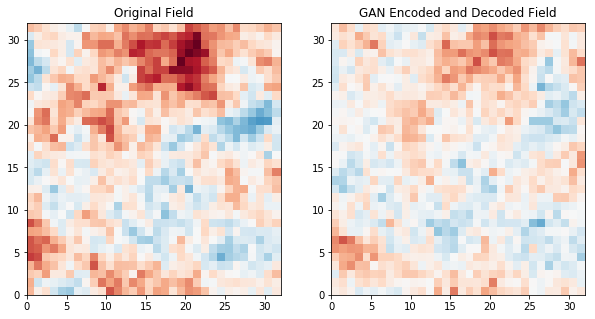

In [60]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Field")
plt.pcolormesh(out_field[0, :, :, 0], vmin=-4, vmax=4, cmap="RdBu_r")
plt.subplot(1,2,2)
plt.title("GAN Encoded and Decoded Field")
plt.pcolormesh(gan_out_field[0, :, :, 0], vmin=-4, vmax=4, cmap="RdBu_r")

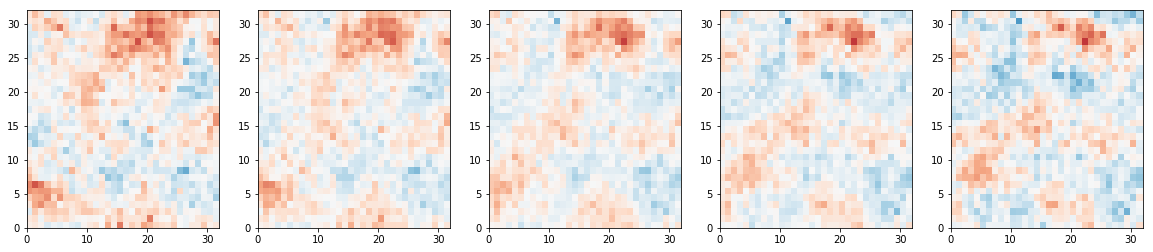

In [85]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
axef = axes.ravel()
for a, ax in enumerate(axef):
    ax.pcolormesh(gen_interp[a, :, :, 0], vmin=-4, vmax=4, cmap="RdBu_r")

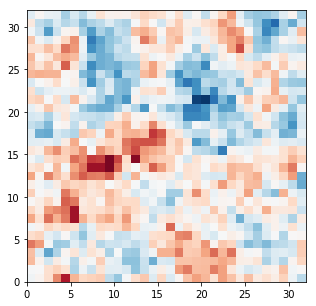

In [67]:
plt.figure(figsize=(5,5))
plt.pcolormesh(out_field[1, :, :, 0], vmin=-3, vmax=3, cmap="RdBu_r")

In [179]:
def encoder_model(input_size=(32, 32, 1), filter_width=5, min_data_width=4,
                    min_conv_filters=64, output_size=100, stride=2):
    """
    Creates an encoder convolutional neural network that reproduces the generator input vector. The keyword arguments
    allow aspects of the structure of the generator to be tuned for optimal performance.

    Args:
        input_size (tuple of ints): Number of nodes in the input layer.
        filter_width (int): Width of each convolutional filter
        min_data_width (int): Width of the last convolved layer
        min_conv_filters (int): Number of convolutional filters in the first convolutional layer
        output_size (int): Dimensions of the output
        stride (int): Number of pixels that the convolution filter shifts between operations.

    Returns:
        Keras convolutional neural network.
    """
    num_layers = int(np.log2(input_size[0]) - np.log2(min_data_width))
    curr_conv_filters = min_conv_filters
    image_input = Input(shape=input_size, name="enc_input")
    model = None
    for c in range(num_layers):
        if c == 0:
            model = Conv2D(curr_conv_filters, filter_width,
                           strides=(stride, stride), padding="same")(image_input)
        else:
            model = Conv2D(curr_conv_filters, filter_width,
                           strides=(stride, stride), padding="same")(model)
        model = LeakyReLU(0.2)(model)
        curr_conv_filters *= 2
    model = Flatten()(model)
    model = Dense(int(curr_conv_filters / 2 * filter_width ** 2))(model)
    model = LeakyReLU(0.2)(model)
    model = Dense(output_size)(model)
    model = Activation("linear")(model)
    return model, image_input

In [275]:
enc_ind, enc_ind_input = encoder_model(min_conv_filters=64, output_size=16)

In [183]:
z_set = np.random.normal(size=(100000, 16))
gen_set = gan_gen.predict(z_set)

In [276]:
enc_ind_model = Model(enc_ind_input, enc_ind)
enc_ind_model.compile(optimizer=Adam(lr=0.0001, beta_1=0.5), loss="mse")